# Cluster Stability & Agreement Demo

In real-world clustering, we often want to check **how stable** or **consistent** our clusters are across different methods or parameter settings.

One simple approach is to run multiple clustering algorithms (or the same algorithm with different `k` or distance thresholds) and compare how often pairs of points get assigned to the **same cluster**.

In this demo, we:
- Run several clustering variants (K-Means with different `k`, Agglomerative with different linkages).
- For each pair of points, count how many times they co-occur in the same cluster.
- Visualize the **agreement matrix** as a heatmap to see which regions of the dataset are robustly grouped together.

This teaches how to **test cluster robustness** and **explore consensus** across methods.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows',100)

plt.style.use('dark_background')

# Make data

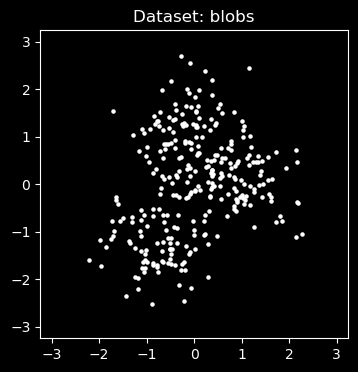

In [2]:
from sklearn.datasets import make_blobs, make_classification, make_moons, make_circles

dataset_type = 'blobs'  # try: blobs, classification, moons, circles, anisotropic, varied

if dataset_type == 'blobs':
    X1, _ = make_blobs(
        n_samples=300,
        centers=3,
        cluster_std=4.5,
        random_state=42
    )

elif dataset_type == 'classification':
    X1, _ = make_classification(
        n_samples=120,
        n_features=2,
        n_redundant=0,
        n_clusters_per_class=1,
        n_classes=3,
        class_sep=2,
        random_state=42
    )

elif dataset_type == 'moons':
    from sklearn.datasets import make_moons
    X1, _ = make_moons(
        n_samples=120,
        noise=0.1,
        random_state=42
    )

elif dataset_type == 'circles':
    from sklearn.datasets import make_circles
    X1, _ = make_circles(
        n_samples=120,
        noise=0.05,
        factor=0.5,
        random_state=42
    )

elif dataset_type == 'anisotropic':
    X1, _ = make_blobs(
        n_samples=120,
        centers=3,
        cluster_std=1,
        random_state=42
    )
    # Apply an anisotropic linear transformation
    transformation = [[0.6, -0.6], [-0.4, 0.8]]
    X1 = X1.dot(transformation)

elif dataset_type == 'varied':
    X1, _ = make_blobs(
        n_samples=120,
        centers=[[-5, -5], [0, 0], [5, 5]],
        cluster_std=[1.0, 2.5, 0.5],
        random_state=42
    )

else:
    raise ValueError("Unknown dataset_type")

# Normalize and add optional noise
n_noise = 0
X1 -= np.mean(X1, axis=0)
MAX = np.max(np.abs(X1))
X2 = np.random.uniform(-MAX, MAX, size=(n_noise, 2))

X = np.concatenate((X1, X2), axis=0)
X -= np.mean(X, axis=0)
X /= np.std(X)
MAX = np.max(np.abs(X)) * 1.2

# Plot
%matplotlib inline

plt.figure(figsize=(4, 4))
plt.scatter(X[:, 0], X[:, 1], c='w', s=5)
plt.xlim(-MAX, MAX)
plt.ylim(-MAX, MAX)
plt.gca().set_aspect('equal')
plt.title(f"Dataset: {dataset_type}")
plt.show()

# Comparing Cluster Assignments with a Cross-Tab

When you run two different clustering models (or the same model with different settings), it’s helpful to check **how their cluster assignments agree**.

A **cross-tabulation** (contingency table) counts how many points from each cluster in `model1` overlap with each cluster in `model2`.  
This shows:
- Which clusters align well across runs.
- Whether clusters split or merge when parameters change.
- How stable or unstable your clusters are.

It’s a simple but powerful way to **diagnose clustering consistency** — especially when you don’t have ground truth labels!

In [3]:
def plot_regions(model):
    
    nGrid = 200
    a1 = np.linspace(-MAX,MAX,nGrid)
    a2 = np.linspace(-MAX,MAX,nGrid)
    
    A1, A2 = np.meshgrid(a1,a2)
    A1 = A1.flatten()
    A2 = A2.flatten()
    A = np.vstack((A1,A2)).T
    
    B = model.predict(A)
    B = B.reshape(nGrid,nGrid)
    B = np.flipud(B)
    
    return B
# end

model2   0   1   2
model1            
0       14   0  81
1       95   0   0
2       11  99   0

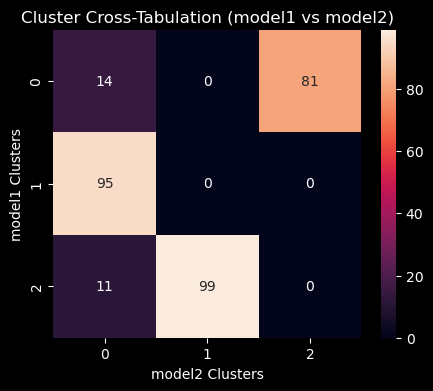

model2 does not support .predict() — skipping region for model2.


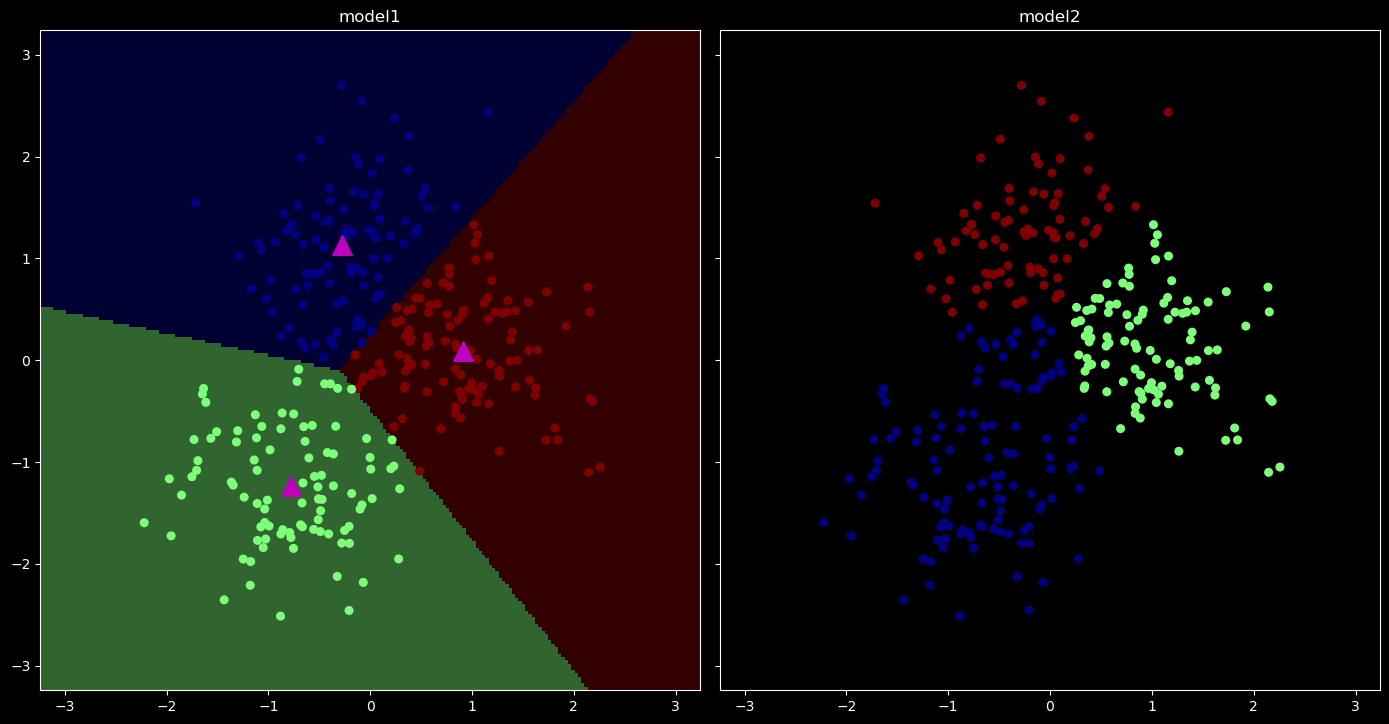

In [4]:
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans, AgglomerativeClustering

N = X.shape[0]

model1 = KMeans(n_clusters=3, random_state=0)
# model2 = KMeans(n_clusters=4, random_state=0)
# model2 = GaussianMixture(n_components=4, random_state=0)
model2 = AgglomerativeClustering(n_clusters=3, linkage='ward')

# --------------------------------
# Fit and get labels
# --------------------------------

labels1 = model1.fit_predict(X)
labels2 = model2.fit_predict(X) if hasattr(model2, 'fit_predict') else model2.predict(X)

# Crosstab of cluster assignments
df = pd.DataFrame({
    'model1': labels1,
    'model2': labels2,
})

ctab = pd.crosstab(df['model1'], df['model2'])
display(ctab)

plt.figure(figsize=(5, 4))
sns.heatmap(ctab, annot=True, square=True, fmt='d')
plt.title("Cluster Cross-Tabulation (model1 vs model2)")
plt.xlabel("model2 Clusters")
plt.ylabel("model1 Clusters")
plt.show()

# --------------------------------
# Plot decision regions if possible, else just points
# --------------------------------

extent = [-MAX, MAX, -MAX, MAX]
cmap = 'jet'

fig, axes = plt.subplots(1, 2, figsize=(14, 7), sharex=True, sharey=True)

try:
    B1 = plot_regions(model1)
    axes[0].imshow(B1, interpolation='none', extent=extent, cmap=cmap, alpha=0.4)
except AttributeError:
    print("model1 does not support .predict() — skipping region for model1.")

axes[0].scatter(X[:, 0], X[:, 1], c=labels1, s=30, cmap=cmap)
if hasattr(model1, 'cluster_centers_'):
    axes[0].scatter(model1.cluster_centers_[:, 0], model1.cluster_centers_[:, 1],
                    marker='^', s=200, c='m')
axes[0].set_title("model1")
axes[0].set_xlim(-MAX, MAX)
axes[0].set_ylim(-MAX, MAX)
axes[0].set_aspect('equal')

try:
    B2 = plot_regions(model2)
    axes[1].imshow(B2, interpolation='none', extent=extent, cmap=cmap, alpha=0.4)
except AttributeError:
    print("model2 does not support .predict() — skipping region for model2.")

axes[1].scatter(X[:, 0], X[:, 1], c=labels2, s=30, cmap=cmap)
axes[1].set_title("model2")
axes[1].set_xlim(-MAX, MAX)
axes[1].set_ylim(-MAX, MAX)
axes[1].set_aspect('equal')

plt.tight_layout()
plt.show()

# Resampling-Based Cluster Stability

One practical way to test **cluster stability** is to run the same clustering algorithm many times on slightly different versions of your dataset.

**Two common ways:**
- **Subsampling:** Randomly pick a fraction (e.g., 80%) of the data each time.
- **Bootstrapping:** Sample *with replacement* so the new sample is the same size as the original (some points repeated, some missing).

For each run:
- Fit K-Means (or other method).
- Record which pairs of points end up in the same cluster.
- Average over runs → you get a **co-occurrence matrix** that shows how consistently pairs of points are grouped together.
- Use matrix for precomputed spectral clustering

Interpreting results:
- Co-occurrence values close to 1 means the points are usually clustered together
- Values close to 0 means the points are usually NOT clustered together
- Values near 0.5 are uncertain and can go either way

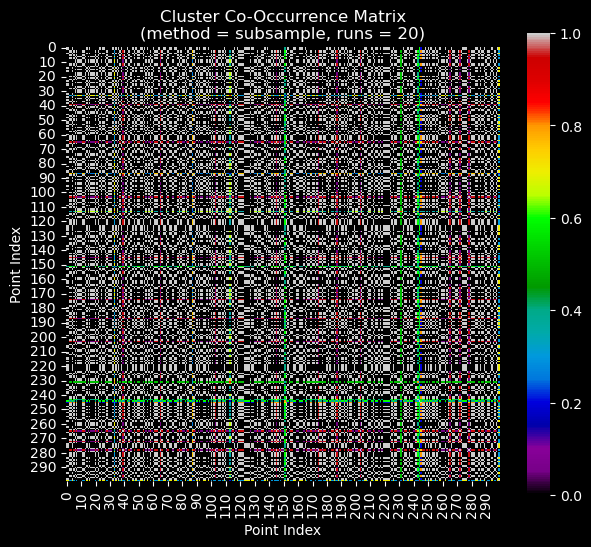

In [10]:
# --------------------------------
# Build co-occurrence matrix + store all labels
# --------------------------------

n_clusters = 3
n_runs = 20
method = 'subsample'
subsample_frac = 0.8

co_matrix = np.zeros((N, N))
labels_runs = []
rng = np.random.default_rng(42)

for run in range(n_runs):
    if method == 'subsample':
        indices = rng.choice(N, size=int(N * subsample_frac), replace=False)
    elif method == 'bootstrap':
        indices = rng.choice(N, size=N, replace=True)
    else:
        raise ValueError("method must be 'subsample' or 'bootstrap'")

    X_resample = X[indices]

    model = KMeans(n_clusters=n_clusters, random_state=0)
    model.fit(X_resample)

    # Predict for all points
    labels_full = model.predict(X)
    labels_runs.append(labels_full)

    # Update co-occurrence for all pairs once (upper triangle)
    for i in range(N):
        for j in range(i + 1, N):
            if labels_full[i] == labels_full[j]:
                co_matrix[i, j] += 1
                co_matrix[j, i] += 1  # mirror

    # Also count self-coincidence
    co_matrix[np.arange(N), np.arange(N)] += 1

co_matrix /= n_runs

# Show heatmap
plt.figure(figsize=(7, 6))
sns.heatmap(co_matrix, square=True, vmin=0, vmax=1, cmap='nipy_spectral')
plt.title(f"Cluster Co-Occurrence Matrix\n(method = {method}, runs = {n_runs})")
plt.xlabel("Point Index")
plt.ylabel("Point Index")
plt.show()

In [8]:
from sklearn.cluster import SpectralClustering

# --------------------------------
# Perform spectral clustering on co-occurrence matrix
# --------------------------------
spectral = SpectralClustering(
    n_clusters=n_clusters,
    affinity='precomputed',
    assign_labels='kmeans',
    random_state=0
)
spectral_labels = spectral.fit_predict(co_matrix)
spectral_labels

array([1, 1, 0, 0, 1, 0, 2, 0, 2, 2, 2, 0, 0, 2, 1, 2, 1, 2, 2, 2, 0, 2,
       0, 1, 2, 1, 1, 2, 0, 2, 2, 2, 1, 2, 1, 2, 1, 0, 1, 0, 0, 2, 1, 0,
       2, 2, 1, 0, 1, 0, 0, 1, 1, 0, 1, 2, 1, 2, 0, 2, 1, 0, 0, 0, 1, 0,
       0, 1, 1, 2, 0, 1, 1, 2, 2, 1, 1, 0, 2, 0, 2, 2, 1, 2, 0, 1, 1, 0,
       0, 2, 1, 2, 1, 2, 2, 1, 1, 2, 1, 2, 0, 2, 0, 0, 2, 0, 0, 2, 0, 1,
       0, 2, 2, 2, 2, 0, 1, 2, 1, 0, 0, 0, 0, 1, 1, 1, 1, 2, 1, 1, 2, 2,
       0, 2, 2, 0, 0, 1, 2, 1, 2, 2, 0, 2, 0, 0, 0, 2, 0, 2, 2, 0, 0, 1,
       2, 0, 0, 1, 1, 2, 2, 1, 1, 1, 2, 1, 0, 2, 2, 0, 2, 2, 0, 2, 0, 0,
       0, 2, 0, 0, 1, 2, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 2, 0, 0,
       2, 1, 2, 2, 0, 0, 2, 0, 1, 1, 0, 2, 2, 1, 0, 2, 1, 1, 2, 1, 2, 1,
       1, 1, 1, 1, 2, 0, 1, 0, 0, 2, 2, 0, 2, 1, 0, 0, 1, 0, 1, 1, 2, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 2, 1, 2, 2, 2, 1, 2,
       0, 0, 1, 0, 0, 2, 2, 0, 0, 0, 1, 1, 1, 2, 0, 2, 0, 0, 0, 1, 1, 0,
       1, 0, 0, 1, 2, 0, 0, 2, 1, 2, 0, 2, 1, 1])

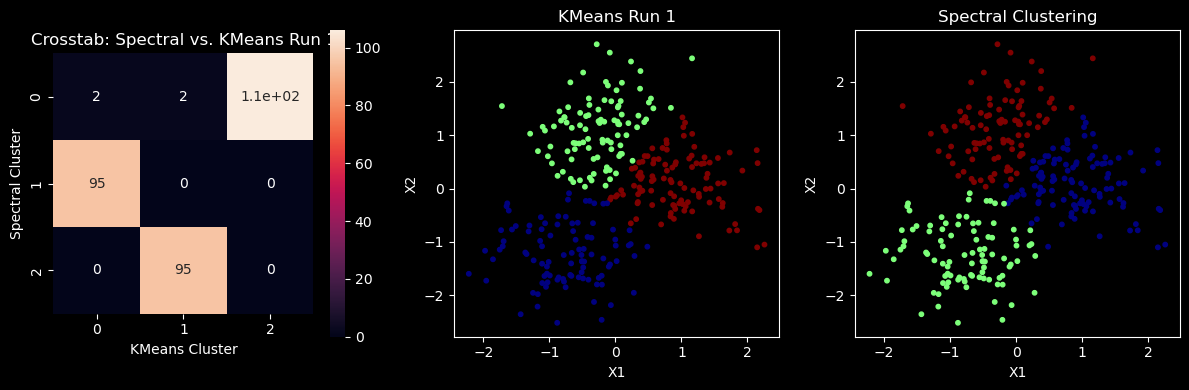

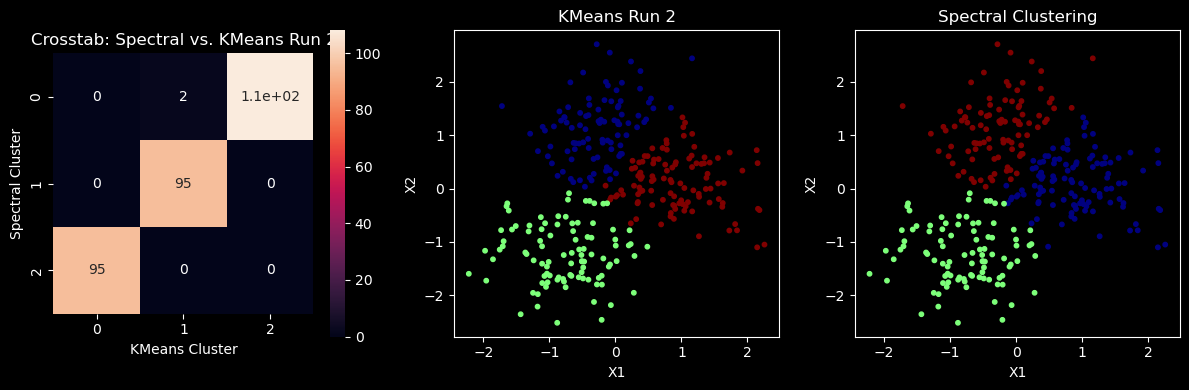

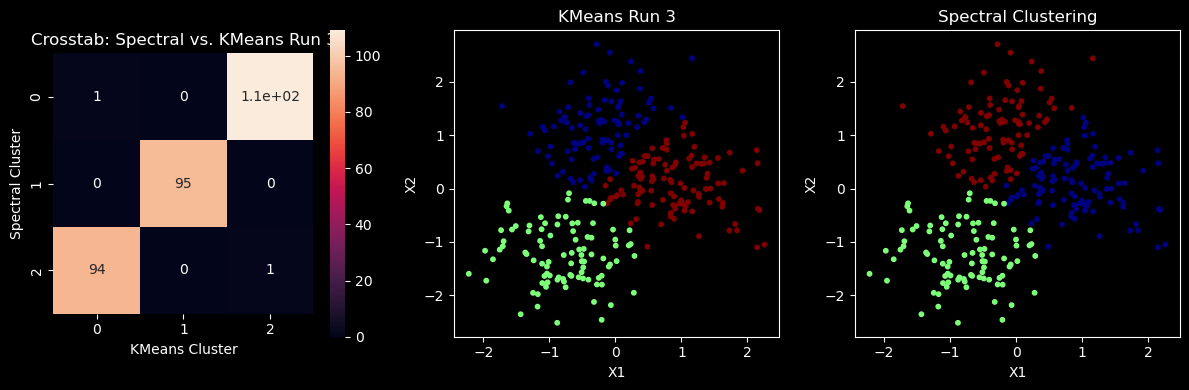

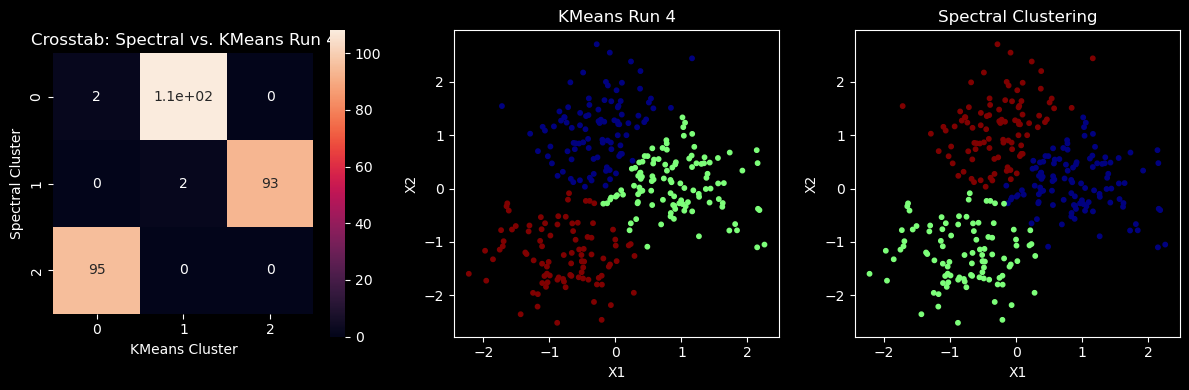

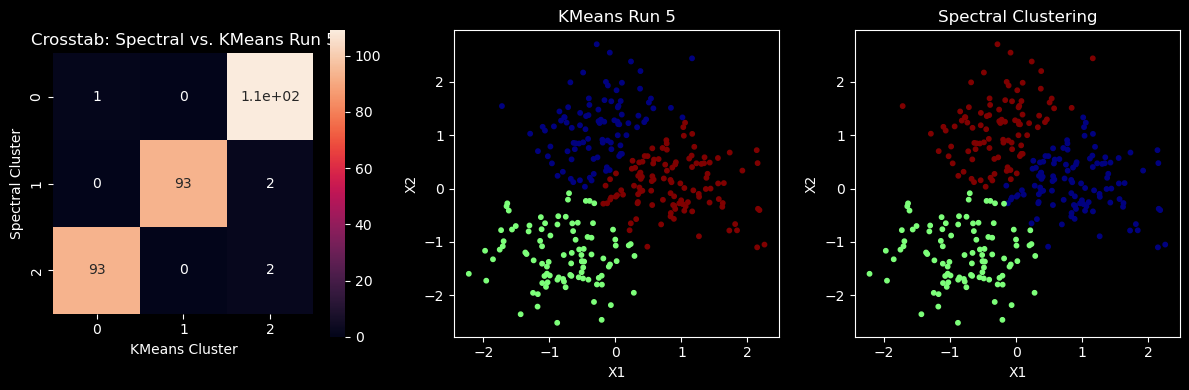

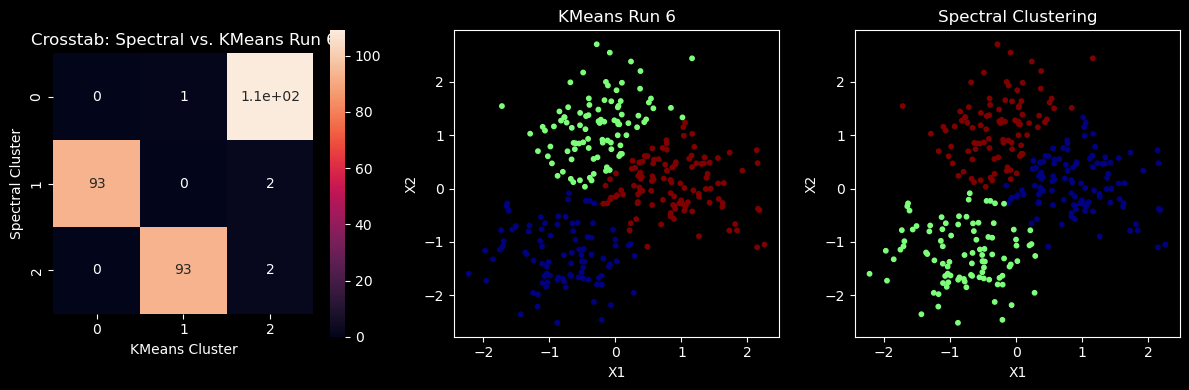

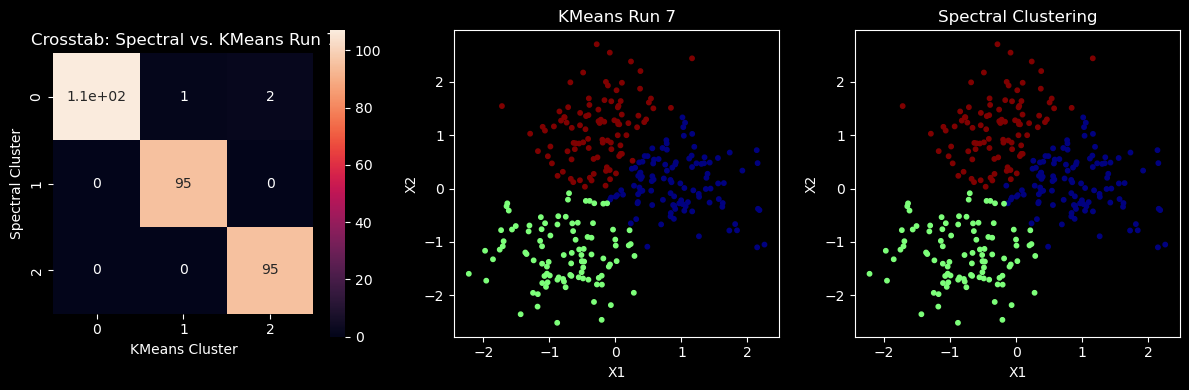

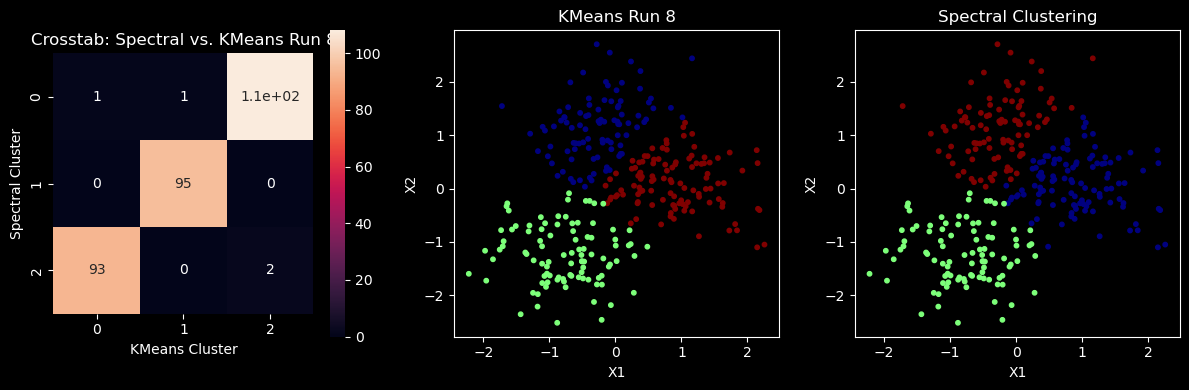

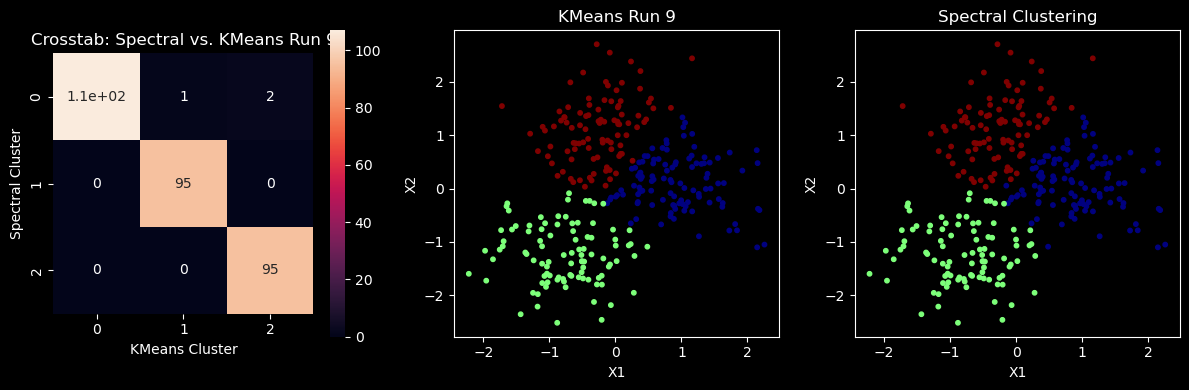

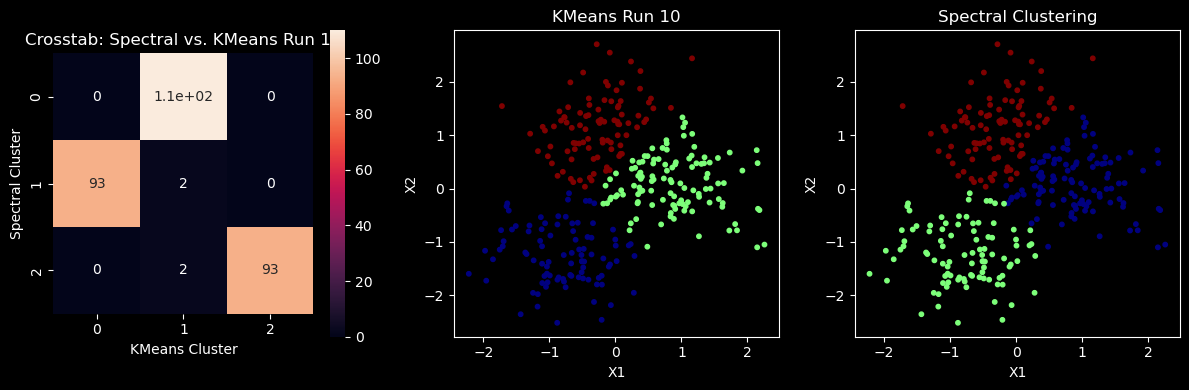

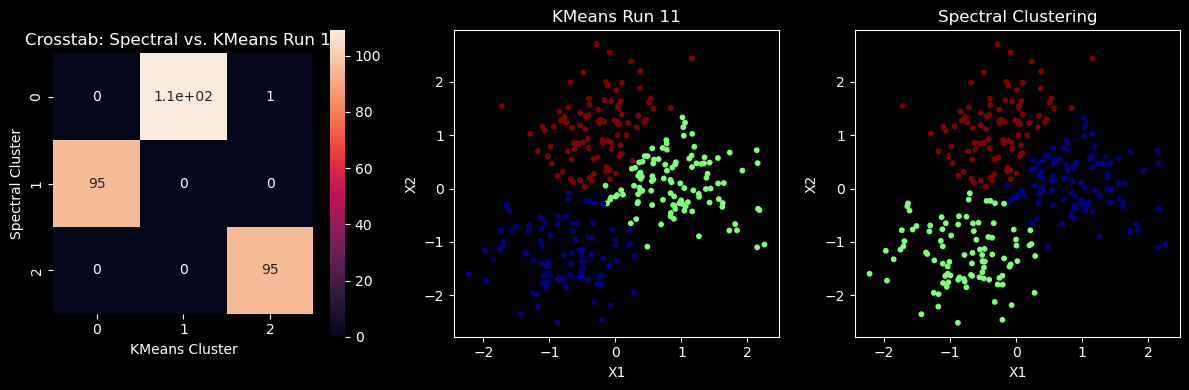

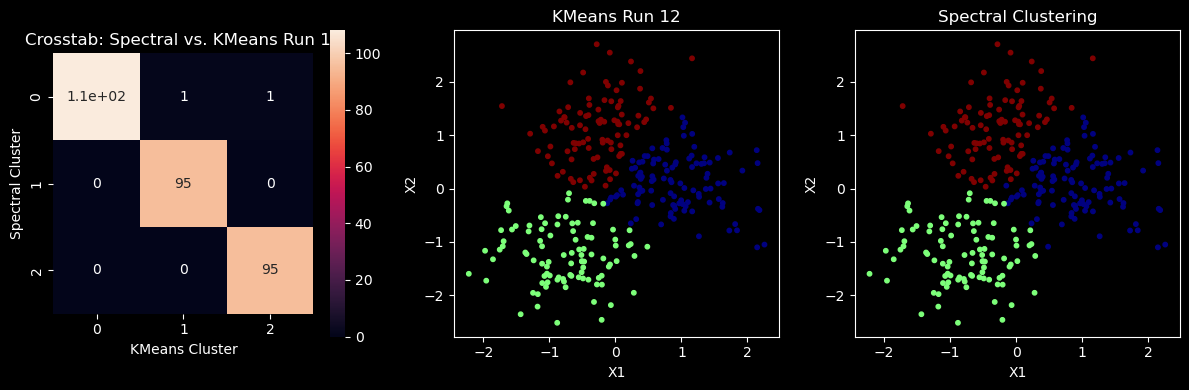

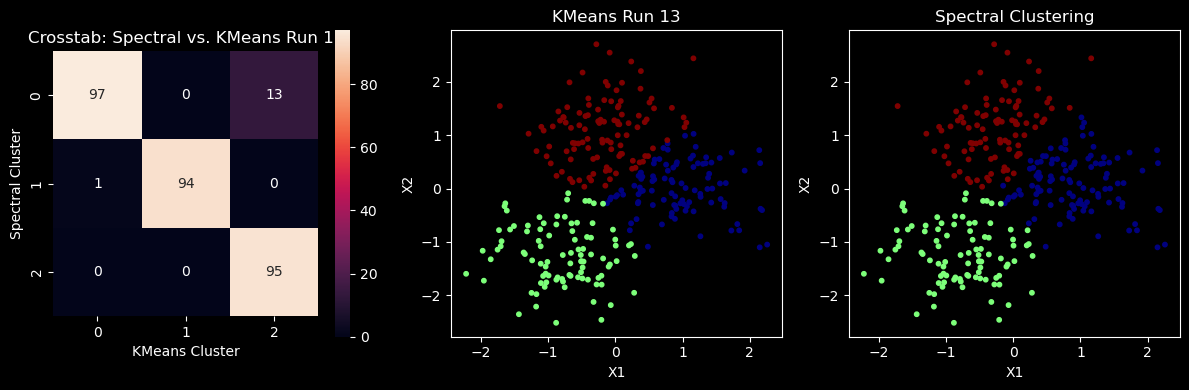

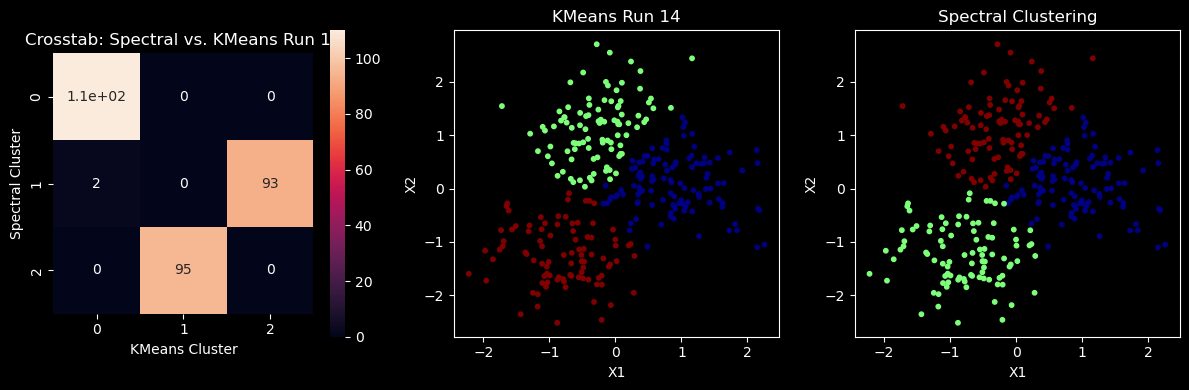

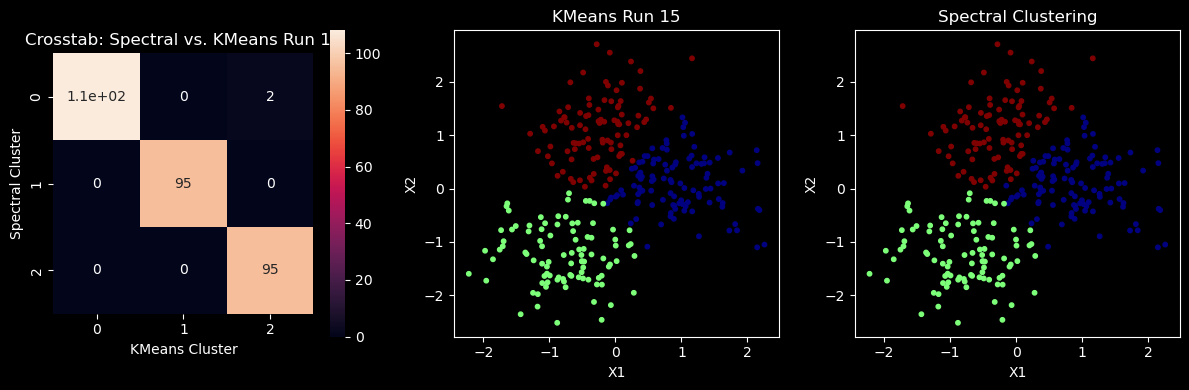

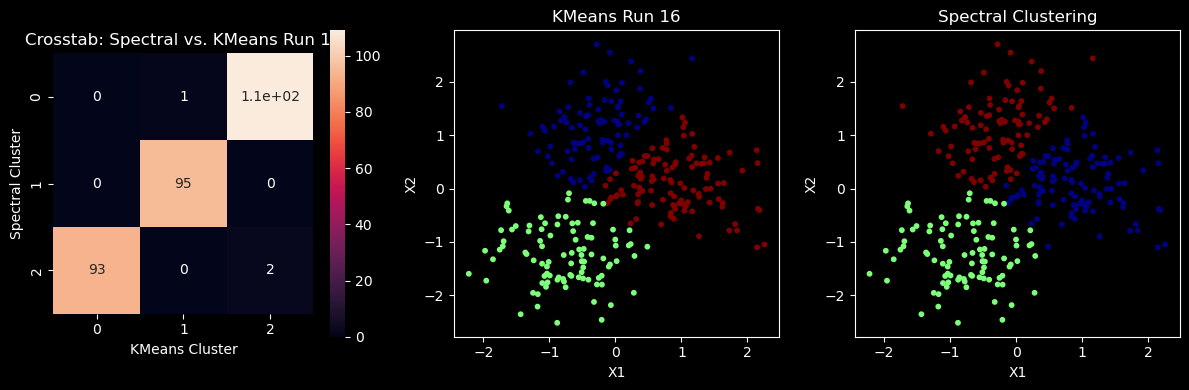

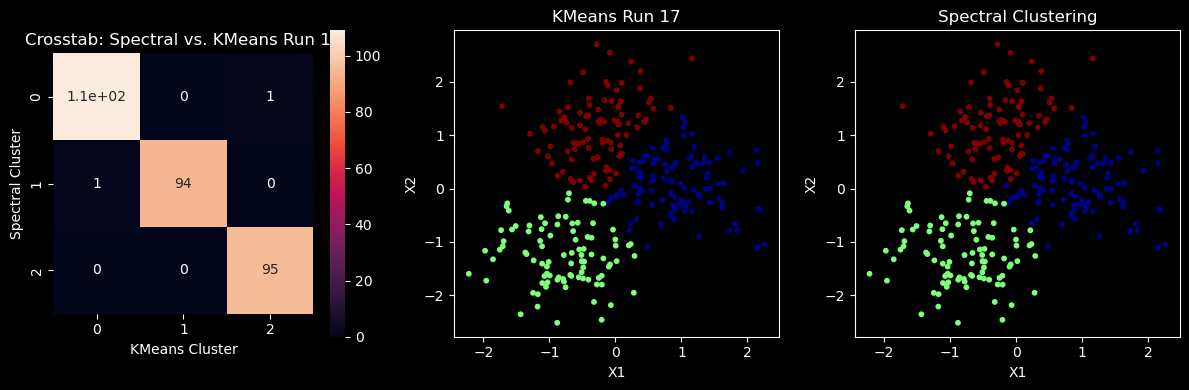

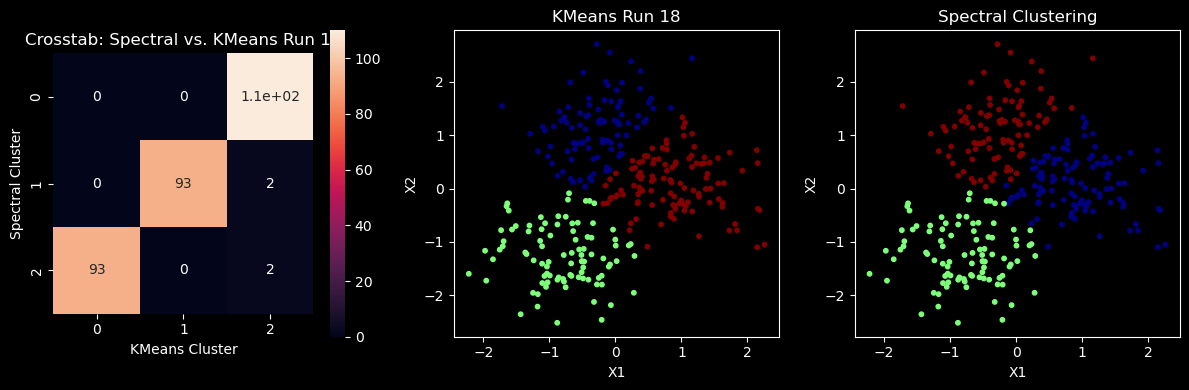

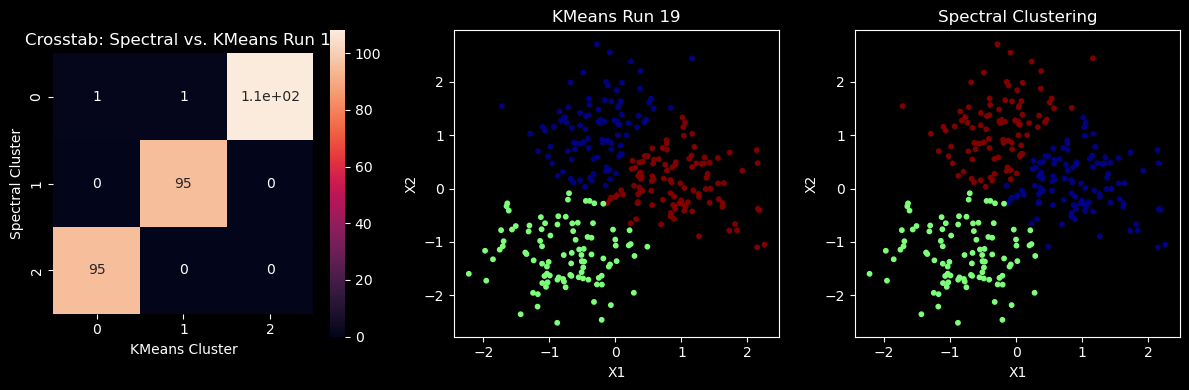

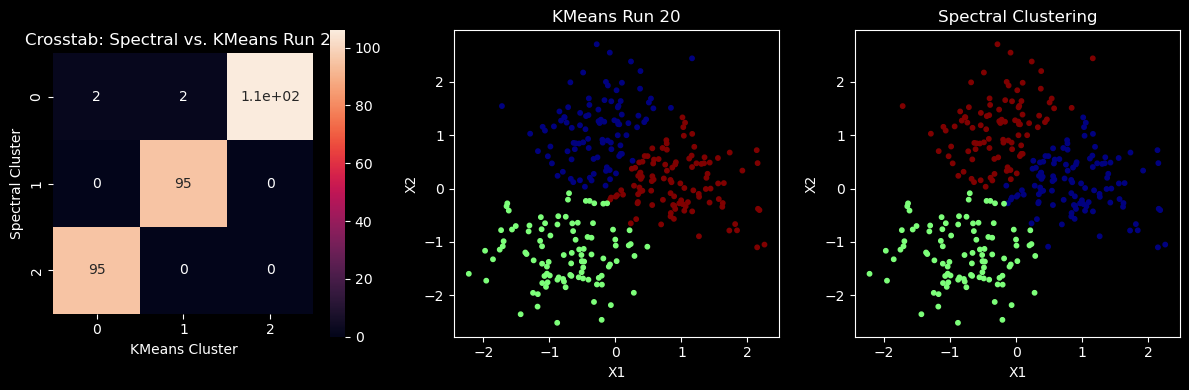

In [9]:
# Example scatterplot colors
cmap = 'jet'

for i, labels_run in enumerate(labels_runs):
    df = pd.DataFrame({
        'Spectral': spectral_labels,
        'KMeans_Run': labels_run,
        'x': X[:, 0],
        'y': X[:, 1],
    })

    ctab = pd.crosstab(df['Spectral'], df['KMeans_Run'])

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    # Heatmap
    sns.heatmap(ctab, annot=True, square=True, ax=axes[0])
    axes[0].set_title(f"Crosstab: Spectral vs. KMeans Run {i+1}")
    axes[0].set_xlabel("KMeans Cluster")
    axes[0].set_ylabel("Spectral Cluster")

    # KMeans scatterplot
    axes[1].scatter(df['x'], df['y'], c=df['KMeans_Run'], cmap=cmap, s=10)
    axes[1].set_title(f"KMeans Run {i+1}")
    axes[1].set_xlabel("X1")
    axes[1].set_ylabel("X2")

    # Spectral scatterplot
    axes[2].scatter(df['x'], df['y'], c=df['Spectral'], cmap=cmap, s=10)
    axes[2].set_title("Spectral Clustering")
    axes[2].set_xlabel("X1")
    axes[2].set_ylabel("X2")

    plt.tight_layout()
    plt.show()

# Perturbation-Based Consensus Clustering

This section demonstrates how to estimate robust, stable clusters using the **perturbation-based consensus method**. 
Instead of relying on a single run of a clustering algorithm, we repeat clustering multiple times on slightly 
perturbed versions of the data and combine the results to find a consensus.

**Key idea:**  
Small random noise is added to the entire dataset multiple times. By tracking how often points stay grouped 
together, we build a co-occurrence matrix that shows the pairwise stability of cluster assignments.

**Steps:**

1. **Perturbation**  
   - For each run, add small Gaussian noise to every sample in the dataset.
   - This tests how sensitive the clustering is to small variations.

2. **Base Clustering**  
   - For each perturbed dataset, fit a clustering model (e.g., KMeans).
   - Predict cluster labels for the original, unperturbed data to keep comparisons consistent.

3. **Co-occurrence Matrix**  
   - For each pair of points, count how often they are assigned to the same cluster across all runs.
   - Normalize these counts to produce a similarity matrix ranging from 0 to 1.

4. **Consensus Clustering**  
   - Apply Spectral Clustering to the co-occurrence matrix.
   - This groups points that frequently co-occur into final consensus clusters.

5. **Compare Runs**  
   - Use crosstab heatmaps to compare each KMeans run to the consensus labels.
   - Visualize both the base clustering results and the final consensus to assess stability.

This approach helps identify stable, meaningful groupings that are less sensitive to noise or random initialization.

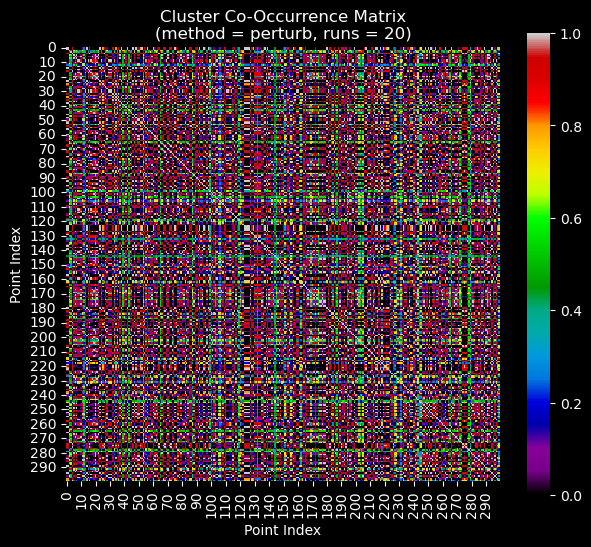

In [17]:
# Parameters
n_clusters = 3
n_runs = 20
noise_std = 1
N = X.shape[0]

co_matrix = np.zeros((N, N))
labels_runs = []
rng = np.random.default_rng(42)

for run in range(n_runs):
    # Perturb: add Gaussian noise to all samples
    X_perturb = X + rng.normal(loc=0.0, scale=noise_std, size=X.shape)

    model = KMeans(n_clusters=n_clusters, random_state=0)
    model.fit(X_perturb)

    # Predict for all points (on original data)
    labels_full = model.predict(X)
    labels_runs.append(labels_full)

    # Update co-occurrence matrix
    for i in range(N):
        for j in range(i + 1, N):
            if labels_full[i] == labels_full[j]:
                co_matrix[i, j] += 1
                co_matrix[j, i] += 1  # mirror

    # Self-pairing
    co_matrix[np.arange(N), np.arange(N)] += 1

co_matrix /= n_runs

# Show co-occurrence heatmap
plt.figure(figsize=(7, 6))
sns.heatmap(co_matrix, square=True, vmin=0, vmax=1, cmap='nipy_spectral')
plt.title(f"Cluster Co-Occurrence Matrix\n(method = perturb, runs = {n_runs})")
plt.xlabel("Point Index")
plt.ylabel("Point Index")
plt.show()

In [18]:
# --------------------------------
# Perform spectral clustering on co-occurrence matrix
# --------------------------------

spectral = SpectralClustering(
    n_clusters=n_clusters,
    affinity='precomputed',
    assign_labels='kmeans',
    random_state=0
)
spectral_labels = spectral.fit_predict(co_matrix)
spectral_labels

array([2, 2, 0, 0, 2, 0, 1, 0, 1, 1, 1, 0, 0, 1, 2, 1, 2, 1, 1, 1, 0, 1,
       0, 2, 1, 2, 2, 1, 0, 1, 1, 1, 2, 1, 2, 1, 2, 0, 2, 1, 0, 1, 2, 0,
       1, 1, 2, 0, 2, 0, 0, 2, 2, 0, 2, 1, 2, 1, 0, 1, 2, 0, 0, 0, 2, 1,
       0, 2, 2, 1, 0, 2, 2, 1, 1, 2, 2, 0, 1, 0, 1, 1, 2, 1, 0, 2, 2, 1,
       0, 1, 2, 1, 2, 1, 1, 2, 2, 1, 2, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 2,
       0, 1, 1, 1, 1, 0, 2, 1, 2, 0, 0, 0, 0, 2, 2, 2, 2, 1, 2, 2, 1, 1,
       0, 1, 1, 0, 0, 2, 1, 2, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 2,
       1, 0, 0, 2, 2, 1, 1, 2, 2, 2, 1, 2, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0,
       0, 1, 0, 0, 2, 1, 2, 0, 0, 2, 0, 0, 2, 0, 2, 2, 0, 2, 0, 1, 0, 0,
       1, 2, 1, 1, 0, 1, 1, 0, 2, 2, 0, 1, 1, 2, 0, 1, 2, 2, 1, 2, 1, 2,
       2, 2, 2, 2, 1, 0, 2, 0, 0, 1, 1, 1, 1, 2, 0, 0, 2, 0, 2, 2, 1, 0,
       0, 1, 0, 2, 0, 0, 2, 0, 2, 0, 2, 0, 0, 2, 0, 1, 2, 1, 1, 1, 2, 1,
       0, 1, 2, 0, 0, 1, 1, 0, 1, 0, 2, 2, 2, 1, 0, 1, 0, 0, 0, 2, 2, 0,
       2, 0, 0, 2, 1, 0, 0, 1, 2, 1, 0, 1, 2, 2])

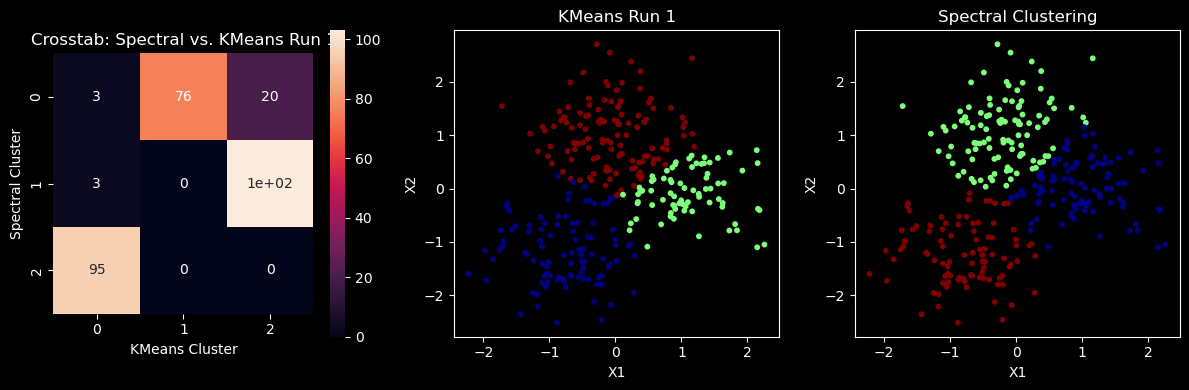

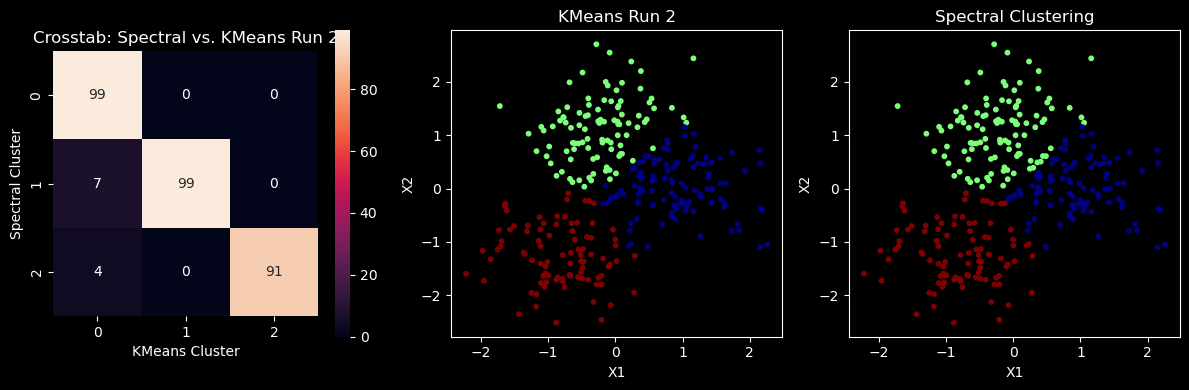

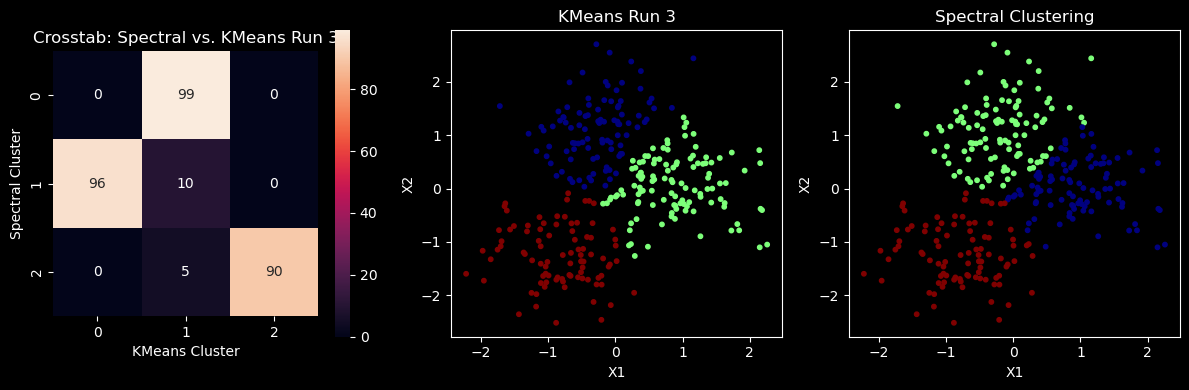

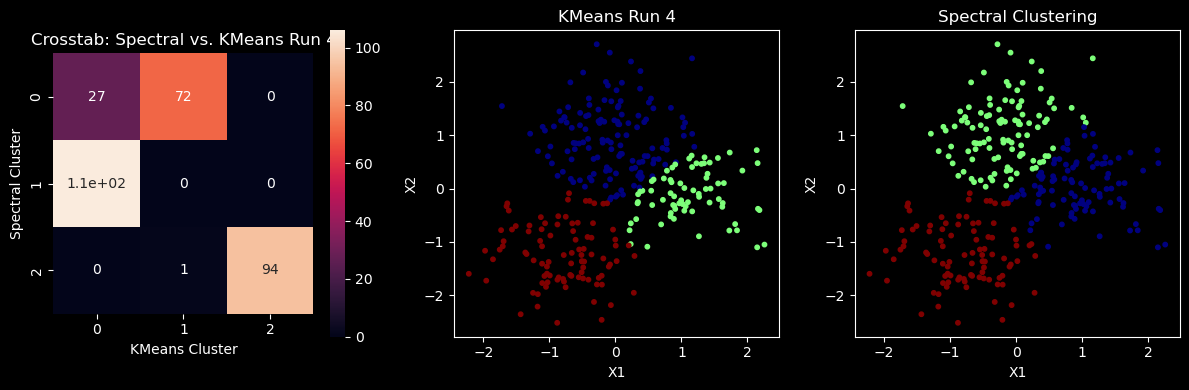

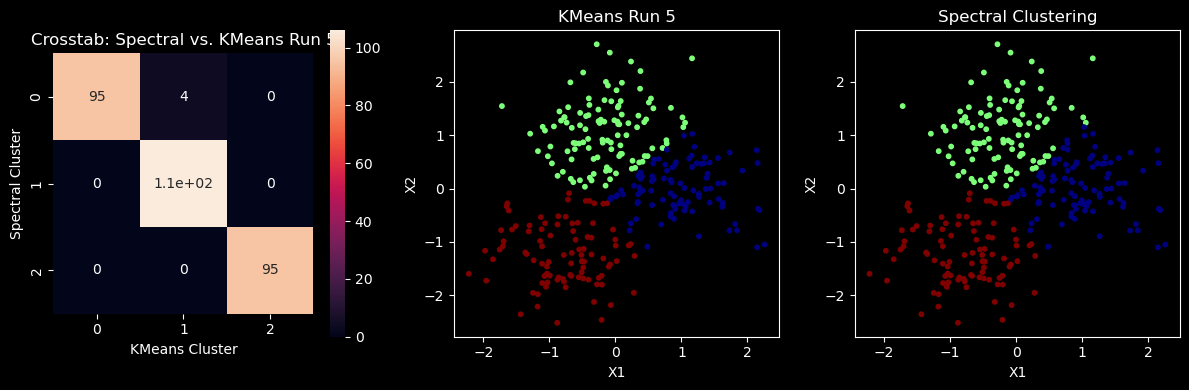

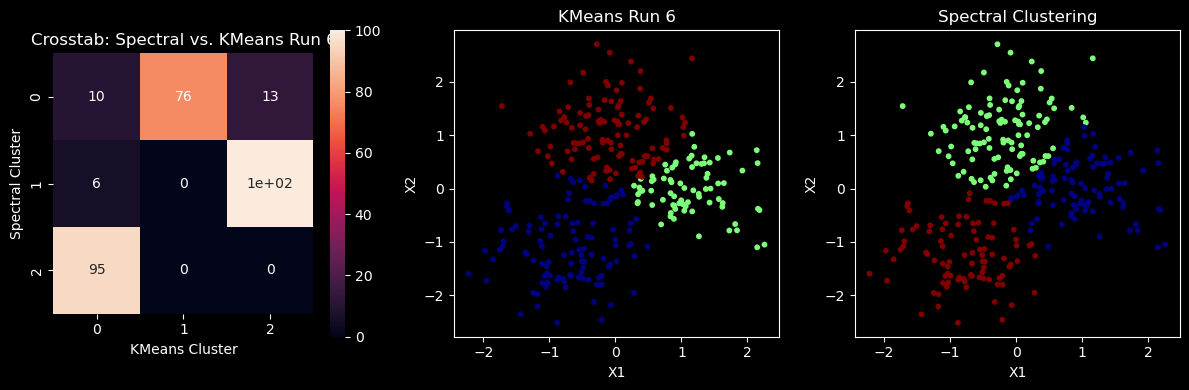

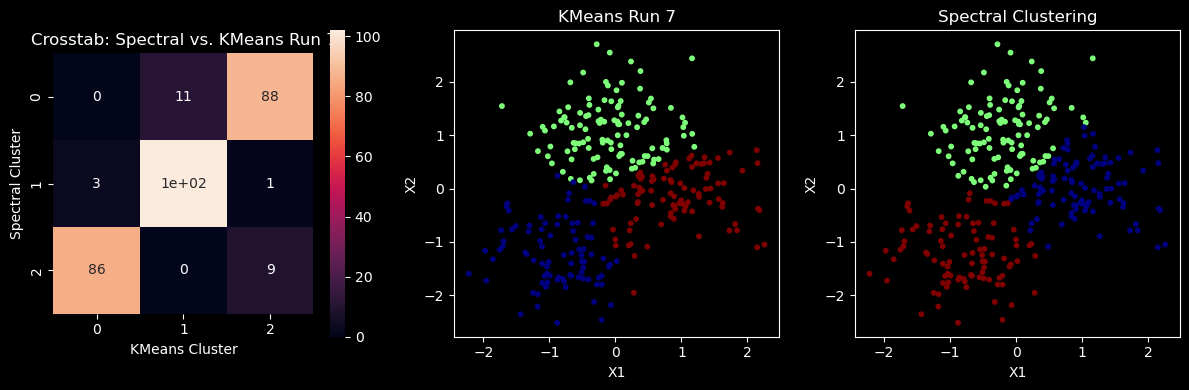

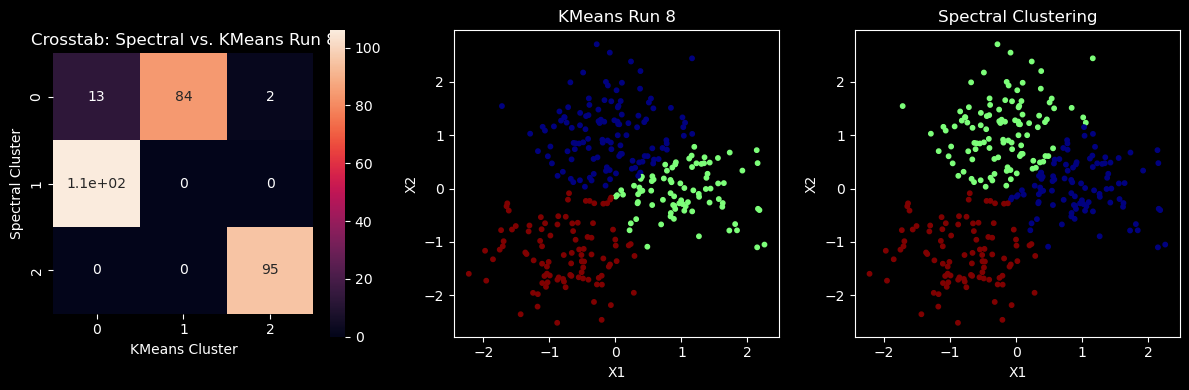

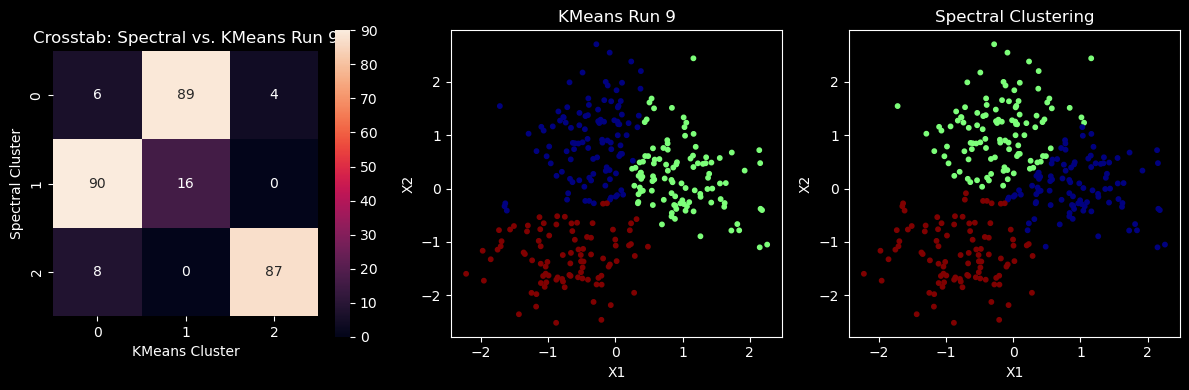

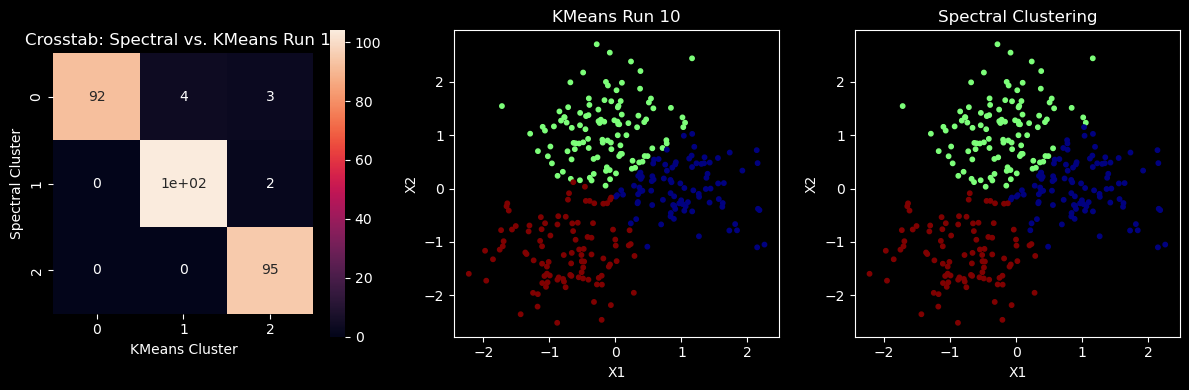

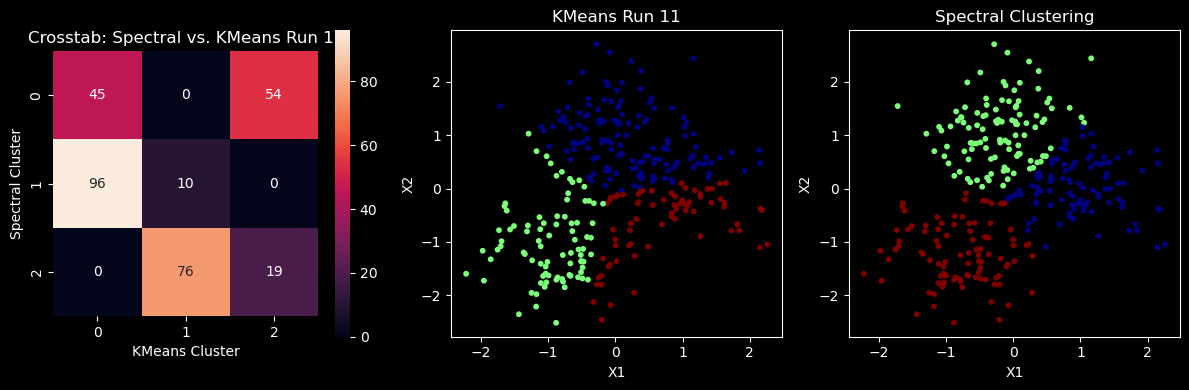

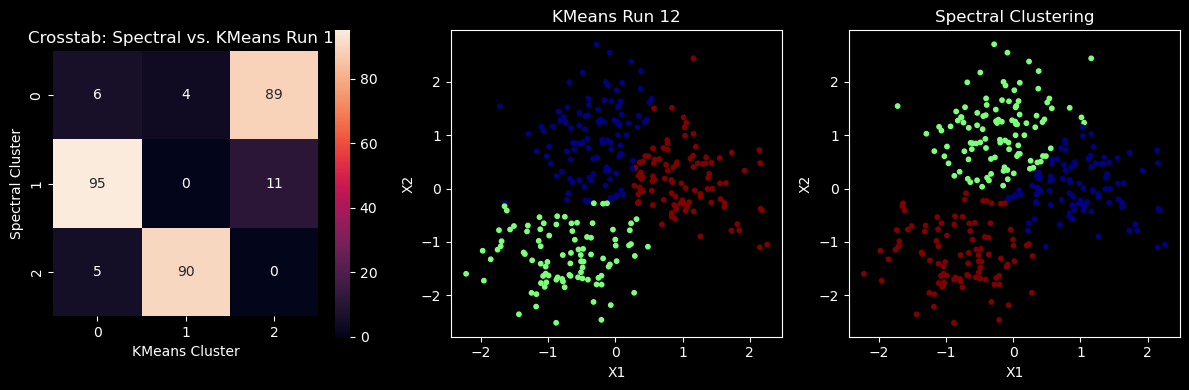

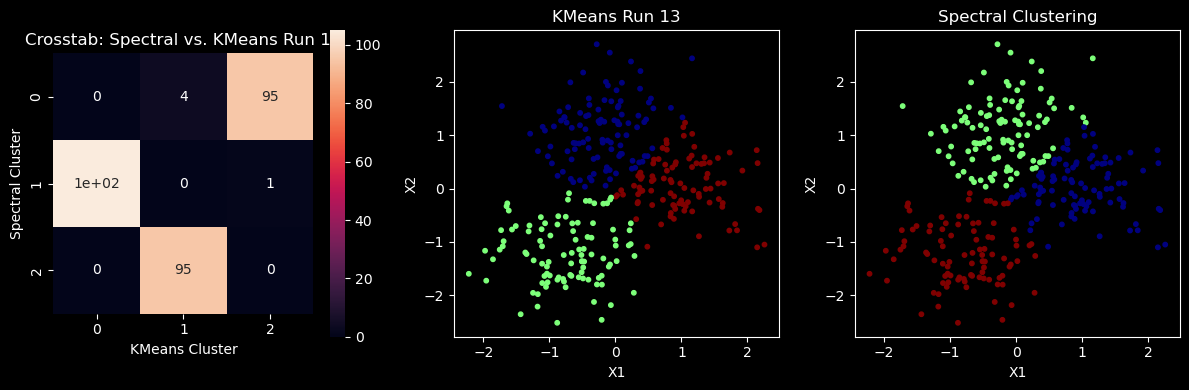

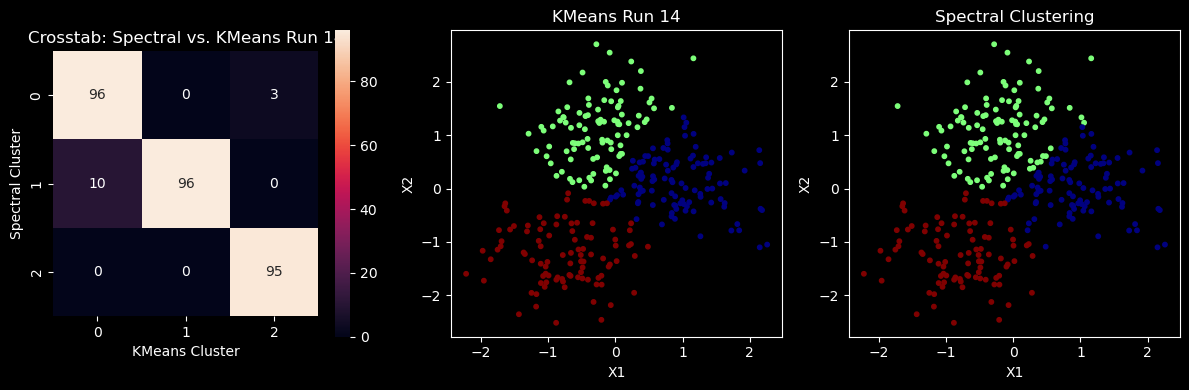

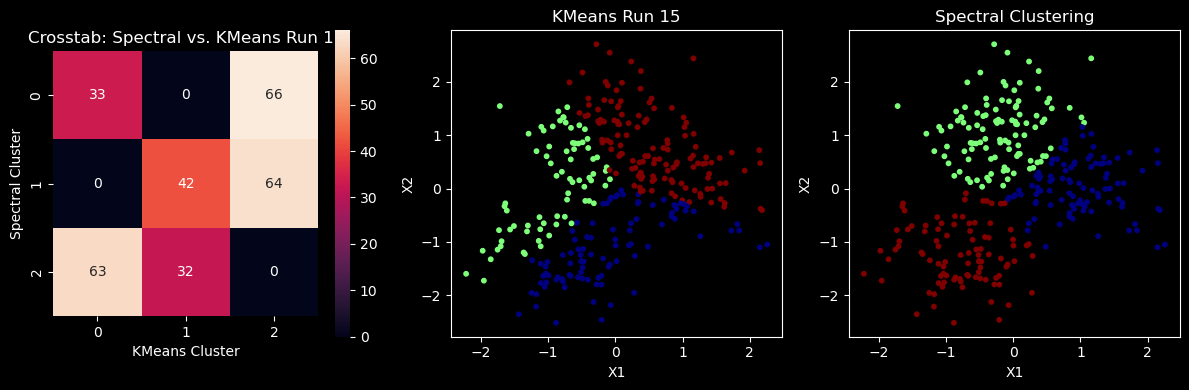

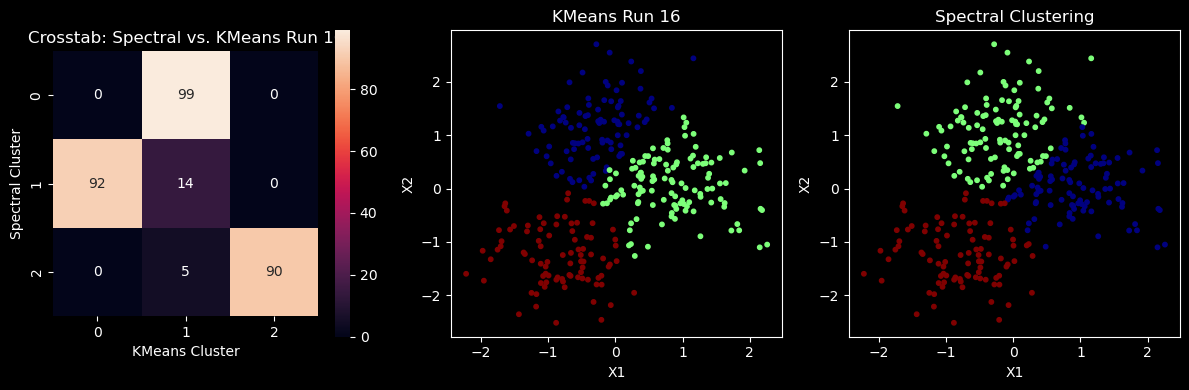

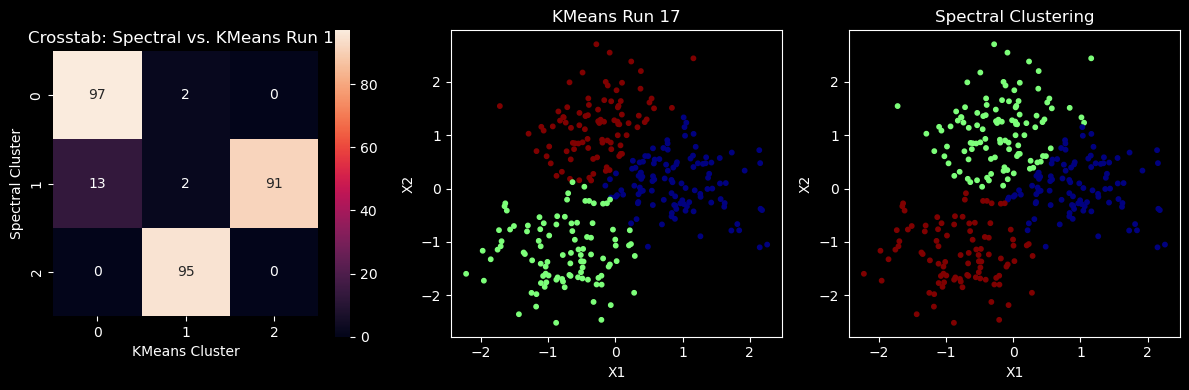

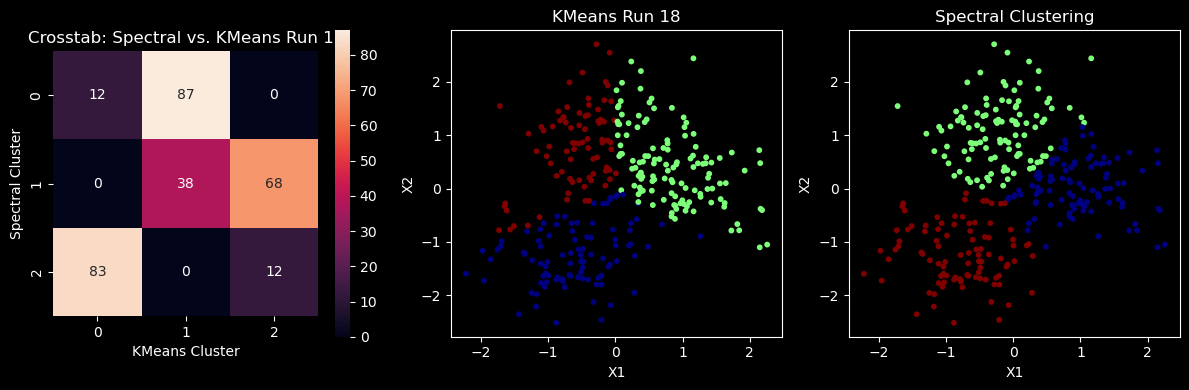

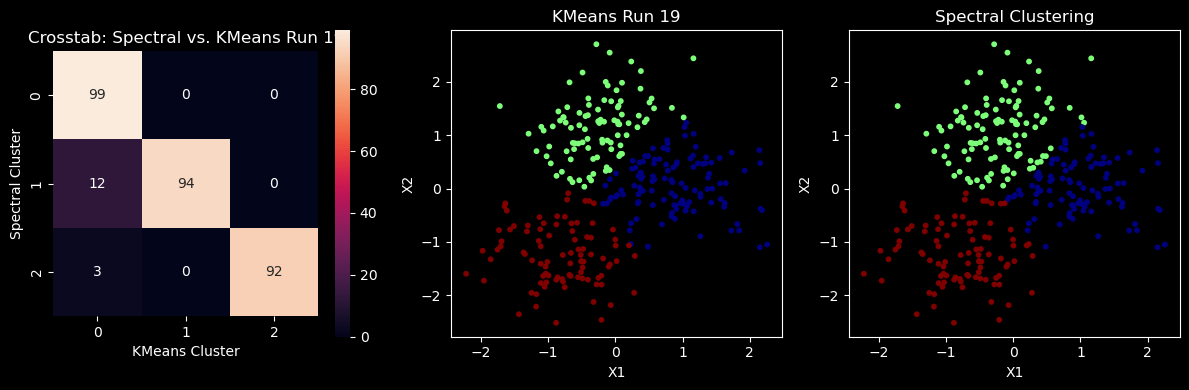

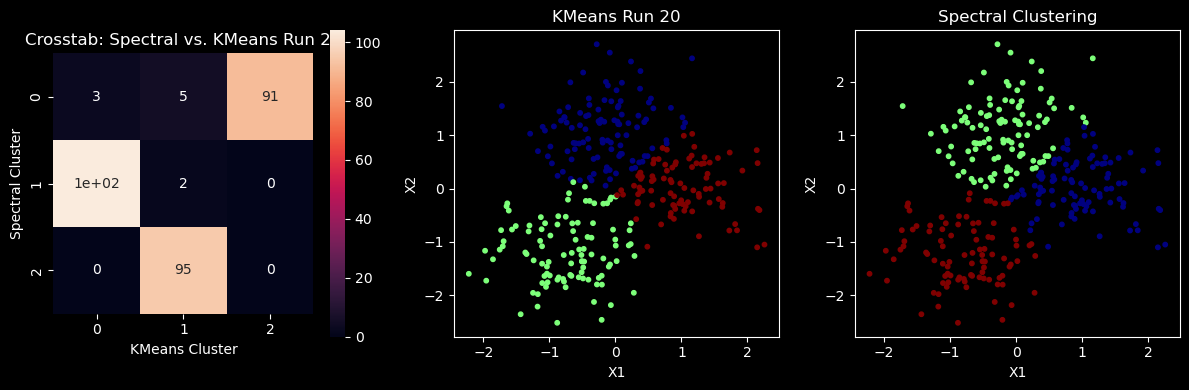

In [19]:
# --------------------------------
# Per Run Comparison: KMeans vs. Spectral
# --------------------------------

cmap = 'jet'

for i, labels_run in enumerate(labels_runs):
    df = pd.DataFrame({
        'Spectral': spectral_labels,
        'KMeans_Run': labels_run,
        'x': X[:, 0],
        'y': X[:, 1],
    })

    ctab = pd.crosstab(df['Spectral'], df['KMeans_Run'])

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    # Heatmap
    sns.heatmap(ctab, annot=True, square=True, ax=axes[0])
    axes[0].set_title(f"Crosstab: Spectral vs. KMeans Run {i+1}")
    axes[0].set_xlabel("KMeans Cluster")
    axes[0].set_ylabel("Spectral Cluster")

    # KMeans scatterplot
    axes[1].scatter(df['x'], df['y'], c=df['KMeans_Run'], cmap=cmap, s=10)
    axes[1].set_title(f"KMeans Run {i+1}")
    axes[1].set_xlabel("X1")
    axes[1].set_ylabel("X2")

    # Spectral scatterplot
    axes[2].scatter(df['x'], df['y'], c=df['Spectral'], cmap=cmap, s=10)
    axes[2].set_title("Spectral Clustering")
    axes[2].set_xlabel("X1")
    axes[2].set_ylabel("X2")

    plt.tight_layout()
    plt.show()